In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [14]:
# Plotting utility in case you want to use it.

import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.callbacks import Callback  # Change this to tensorflow.keras if you want.
from keras.callbacks import ReduceLROnPlateau

class PlotLosses(Callback):
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        fig, axes = plt.subplots(1,2,figsize=(8,3))
        
        axes[0].plot(self.x, self.losses, label="Train loss")
        axes[0].plot(self.x, self.val_losses, label="Validation loss")
        #axes[0].set_yscale('log')
        axes[0].set_xlabel('Number of epochs')
        axes[0].set_ylabel('Losses')
        axes[0].legend()
            
        axes[1].plot(self.x, self.acc, label="Train accuracy")
        axes[1].plot(self.x, self.val_acc, label="Validation accuracy")
        axes[1].set_xlabel('Number of epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show();

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True, vertical_flip=True, validation_split=0.2, rotation_range=360.)

train_generator = train_datagen.flow_from_directory(
    directory='images',
    class_mode='categorical',
    batch_size=32,
    target_size=(32, 32),
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    directory='images',
    class_mode='categorical',
    batch_size=32,
    target_size=(32, 32),
    subset='validation'
)

Found 1652 images belonging to 4 classes.
Found 411 images belonging to 4 classes.


In [16]:
# Read in the catalog data
with open('training_galaxies.dat') as f:
    names = f.readline().rstrip().strip("#").split()
    df = pd.read_csv(f, sep=r'\s+', names=names)
df.info()

# Pull out the target column from the rest.
gal_type = df['gal_type']
df = df.drop('gal_type', axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2063 non-null   int64  
 1   gal_type        2063 non-null   int64  
 2   ra              2063 non-null   float64
 3   dec             2063 non-null   float64
 4   redshift        2063 non-null   float64
 5   log_luminosity  2063 non-null   float64
 6   color           2063 non-null   float64
 7   radius          2063 non-null   float64
 8   b_over_a        2063 non-null   float64
 9   pos_angle       2063 non-null   float64
 10  bulge_fract     2063 non-null   float64
 11  sersic_n        2063 non-null   float64
 12  r_bulge         2063 non-null   float64
 13  r_disk          2063 non-null   float64
dtypes: float64(12), int64(2)
memory usage: 225.8 KB


In [77]:
# Put whatever keras or tensorflow imports you need here.
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, Conv2D, MaxPooling2D, Reshape, UpSampling2D
from keras.optimizers import Adam

def train_cnn(train_generator, val_generator):
    """Do some kind of training to learn how to predict the galaxy type from the given training images.
    
    Returns the trained convolutional neural net
    """
    # Hint: With the generators, the fit call should look like
    #       cnn.fit(train_generator, validation_data=val_generator, ...)
    #       The generators already have the gal_type information encoded into the directory names.
    #       (images/1/*, images/2/*, etc.)  So you don't need to also include the gal_type anywhere.
    
    ### YOUR CODE HERE
    plot_losses = PlotLosses()
    x = Input(shape=(32,32,3))
    #2D layers
    h = Conv2D(filters = 128, kernel_size=(4,4), activation='relu')(x)
    h = Conv2D(filters = 128, kernel_size=(2,2), activation='relu')(x)

    #Pool accross image by taking 2*2 batches of pixels and replacing them with maximum values inside
    
    h = MaxPooling2D((2,2))(h)
    
    #Repeat twice, doubling filters
    h = Conv2D(filters = 64, kernel_size=(3,3), activation='relu')(h)
    
    #h = MaxPooling2D((2,2))(h)
    
    h = Conv2D(filters=32,kernel_size=(3,3), activation='relu')(h)
    
    #h = MaxPooling2D((2,2))(h)
    #Flatten image to be compatible with dense layer instead of being a tensor
    h = Flatten()(h)
    h = Dense(128,activation='relu')(h)
    h = Dropout(rate = 0.2)(h)
    h = Dense(64,activation='relu')(h)
    h = Dropout(rate = 0.2)(h)
    h = Dense(32,activation='relu')(h)
    #Output layer a 4 neuron system to classify which of 4 classes image belongs to
    y = Dense(4,activation='softmax')(h)
    
    model = Model(x,y)
    #categorical crossentropy good option for classification (not binary)
    model.compile(optimizer=Adam(learning_rate=0.003), loss='categorical_crossentropy', metrics =['accuracy'])
    #epochs by trial so that loss stable
    model.fit(train_generator, validation_data=val_generator, epochs = 30, 
              callbacks=[plot_losses])
    return model

def cnn_predict(cnn, images):
    """Use the convolutional neural net from the above function to predict the galaxy type for some validation images.
    
    Returns predictions for the galaxy type of these galaxies.
    """
    ### YOUR CODE HERE
    images /= 255.
    pred = cnn.predict(images)
    gal_predictions = []
    for i in pred:
        print(pred)
        category = np.argmax(i) + 1
        gal_predictions.append(category)
        
    return np.asarray(gal_predictions)

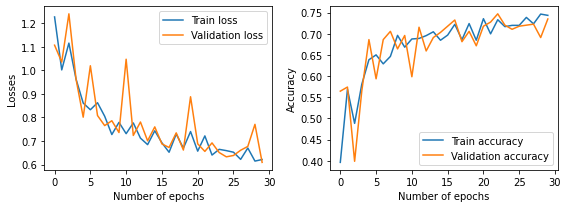

33/33 [==============================] - 1s 15ms/step
Num correct =  786
Num total =  1032
Fraction correct =  0.7616279069767442


In [63]:
from tensorflow.keras.utils import img_to_array, load_img

# In this case, the image generators will generate random flips of all our input images, so we will actually
# use all the input images for training the CNN.  However, to be at least a little consistent with the
# previous parts, we still split the data, and we'll use just half the images for testing.
X_train, X_test, Y_train, Y_test = train_test_split(df, gal_type, test_size = 0.5, random_state=1234)

# Make some kind of classifier and train it
cnn = train_cnn(train_generator, val_generator)

test_images = np.array([img_to_array(load_img('images/{}/{}.jpg'.format(gt, ID), target_size=(32,32))) 
                        for gt,ID in zip(Y_test, X_test['id'])])

Y_pred = cnn_predict(cnn, test_images)

print('Num correct = ',np.sum(Y_pred == Y_test))
print('Num total = ',len(Y_test))
print('Fraction correct = ',np.sum(Y_pred == Y_test) / len(Y_test))


In [66]:

test_images = np.array([img_to_array(load_img('images/{}/{}.jpg'.format(gt, ID), target_size=(32,32))) 
                        for gt,ID in zip(Y_test, X_test['id'])])
Y_pred = cnn_predict(cnn, test_images)

print('Num correct = ',np.sum(Y_pred == Y_test))
print('Num total = ',len(Y_test))
print('Fraction correct = ',np.sum(Y_pred == Y_test) / len(Y_test))

33/33 [==============================] - 0s 11ms/step
Num correct =  786
Num total =  1032
Fraction correct =  0.7616279069767442


In [67]:
cnn.save("CNN-76")

INFO:tensorflow:Assets written to: CNN-76\assets


INFO:tensorflow:Assets written to: CNN-76\assets


In [57]:
import keras

In [73]:
model = keras.models.load_model("CNN-76")

test_images = np.array([img_to_array(load_img('images/{}/{}.jpg'.format(gt, ID), target_size=(32,32))) 
                        for gt,ID in zip(Y_test, X_test['id'])])
Y_pred = cnn_predict(model, test_images)

print('Num correct = ',np.sum(Y_pred == Y_test))
print('Num total = ',len(Y_test))
print('Fraction correct = ',np.sum(Y_pred == Y_test) / len(Y_test))

33/33 [==============================] - 0s 13ms/step
Num correct =  786
Num total =  1032
Fraction correct =  0.7616279069767442


In [74]:
test_img = img_to_array(load_img("galaxy.jpg", target_size=(32,32)))

In [78]:
cnn_predict(model, np.array([test_img]))

1/1 [==============================] - 0s 16ms/step
[[1.2163479e-06 2.4131186e-04 9.0937413e-02 9.0882015e-01]]


array([4], dtype=int64)

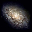

In [79]:
load_img("galaxy.jpg", target_size=(32,32))

In [ ]:
network = [
    Input((4,1)),
    Dense(64, activation = "relu"),
    Dense(32, activation = "relu"),
    Dense(16, activation = "relu")
]